In [5]:
from llama_index.finetuning import EmbeddingQAFinetuneDataset
from loguru import logger

# load dataset

In [6]:
dataset_name = "QA/gpt-35-turbo_dataset.json"

it_dataset = EmbeddingQAFinetuneDataset.from_json(dataset_name)

keys_to_delete = [key for key in it_dataset.corpus.keys() if it_dataset.corpus[key] == '']
for key in keys_to_delete:
    del it_dataset.corpus[key]

In [32]:
it_dataset

EmbeddingQAFinetuneDataset(queries={'6c67a361-1d84-4876-8ed5-72e11dd2f21e': "Qual è la data del documento di lavoro dei servizi della Commissione Europea sulla relazione per paese 2025 dell'Italia?", '5377179f-f310-4498-9a81-4a644d21eef6': "Domanda 1: Quali sono le sfide e i ritardi affrontati nell'attuazione del piano per la ripresa e la resilienza in Italia?", 'a980095d-5cd4-4112-9b80-d3d1e7023f44': 'Quali sono gli indicatori chiave per monitorare i progressi in materia di adattamento ai cambiamenti climatici, resilienza e ambiente secondo la Tabella A9.1?', '364684a1-eafa-4081-ba35-bb669d1657b7': "Qual è il limite stabilito dalla norma UE sull'acqua potabile per il contenuto di nitrati?", '2356fbfa-7df2-467d-ac72-ef26ed474fff': 'Quali sono le principali sfide strutturali che il mercato del lavoro italiano deve affrontare?', '4076be16-ad8b-404a-be85-d9625d6e0d4a': 'Domanda 1: Qual è il divario percentuale tra il tasso di occupazione del Nord-Est e quello del Sud?', '1eff24e6-64f6-430

# Sample QA dataset

In [41]:
print(it_dataset.queries["6c67a361-1d84-4876-8ed5-72e11dd2f21e"])
print(it_dataset.relevant_docs["6c67a361-1d84-4876-8ed5-72e11dd2f21e"])
print(it_dataset.corpus["80b9998c-32d4-42f7-94a7-1a36155b382b"])

Qual è la data del documento di lavoro dei servizi della Commissione Europea sulla relazione per paese 2025 dell'Italia?
['80b9998c-32d4-42f7-94a7-1a36155b382b']
IT   IT 
 
 
 COMMISSIONE  
EUROPEA   
Bruxelles, 4.6.2025  
SWD(2025) 212 final  
 
DOCUMENTO DI LAVORO DEI SERVIZI DELLA COMMISSIONE  
Relazione per paese 2025 - Italia  
che accompagna il documento  
Raccomandazione di RACCOMANDAZIONE DEL CONSIGLIO  
sulle politiche economiche, sociali, occupazionali, strutturali e di bilancio dell'Italia  
{COM(2025)  212 final}


# HuggingFace: paraphrase-multilingual-MiniLM-L12-v2

In [35]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

embed_model_paraphrase_l12 = HuggingFaceEmbedding(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


# Validation


In [77]:
from llama_index.core import VectorStoreIndex
from llama_index.core import Settings
from llama_index.core.schema import TextNode
from tqdm import tqdm

def evaluate(dataset, embed_model, top_k=5, verbose=False):
    """ Evaluate the dataset using the provided embedding model and return evaluation results. 
    Args:
        dataset (EmbeddingQAFinetuneDataset): The dataset to evaluate.
        embed_model: The embedding model to use for evaluation.
        top_k (int): The number of top results to consider for evaluation.
        verbose (bool): Whether to print detailed evaluation information.
    Returns:
        list: A list of evaluation results containing hit status, MRR, retrieved IDs, expected ID, and query ID.
    """
    import pandas as pd
    
    corpus = dataset.corpus
    queries = dataset.queries
    relevant_docs = dataset.relevant_docs

    nodes = [TextNode(id_=id_, text=text) for id_, text in corpus.items()]
    index = VectorStoreIndex(
        nodes, embed_model=embed_model, show_progress=True
    )
    retriever = index.as_retriever(similarity_top_k=top_k)

    eval_results = []
    for query_id, query in tqdm(queries.items()):
        retrieved_nodes = retriever.retrieve(query)
        retrieved_ids = [node.node.node_id for node in retrieved_nodes]
        expected_id = relevant_docs[query_id][0]
        is_hit = expected_id in retrieved_ids  # assume 1 relevant doc
        if is_hit:
            rank = retrieved_ids.index(expected_id) + 1
            mrr = 1 / rank
        else:
            mrr = 0

        eval_result = {
            "is_hit": is_hit,
            "mrr": mrr,
            "retrieved": retrieved_ids,
            "expected": expected_id,
            "query": query_id,
        }
        eval_results.append(eval_result)
    return pd.DataFrame(eval_results)

In [ ]:
top_k = 5
df_paraphrase_l12_results_it = evaluate(dataset=it_dataset, 
                                        embed_model=embed_model_paraphrase_l12, 
                                        top_k=top_k, 
                                        verbose=True)
print(len(df_paraphrase_l12_results_it))
df_paraphrase_l12_results_it.head()

100%|██████████| 260/260 [00:03<00:00, 79.20it/s]

260


,is_hit,mrr,retrieved,expected,query
0,True,1.0,"[80b9998c-32d4-42f7-94a7-1a36155b382b, ca82b43...",80b9998c-32d4-42f7-94a7-1a36155b382b,6c67a361-1d84-4876-8ed5-72e11dd2f21e
1,False,0.0,"[e81fb935-4ea8-4a80-867d-ed15f40d0a0c, 0ddb84a...",93b772d4-52a6-44a6-a331-0eae1fdf33a5,5377179f-f310-4498-9a81-4a644d21eef6
2,True,1.0,"[f612986a-0b1a-4c12-bdf1-2c2107733db7, f1b6e8e...",f612986a-0b1a-4c12-bdf1-2c2107733db7,a980095d-5cd4-4112-9b80-d3d1e7023f44
3,True,1.0,"[b87e8ec1-9380-48ad-9428-47c47ede0e76, c0f6569...",b87e8ec1-9380-48ad-9428-47c47ede0e76,364684a1-eafa-4081-ba35-bb669d1657b7
4,True,0.5,"[e96386a3-3796-457d-875e-2d6c7bdab02f, 4a5026b...",4a5026bd-2856-497f-8276-9de39b7562e6,2356fbfa-7df2-467d-ac72-ef26ed474fff


In [48]:
import numpy as np
set_embeddings = []
for id_, text in tqdm(it_dataset.corpus.items()):
    embedding = embed_model_paraphrase_l12.get_text_embedding(text)
    set_embeddings.append(embedding)
array_embeddings = np.array(set_embeddings)

100%|██████████| 258/258 [00:03<00:00, 71.20it/s]


In [60]:
from sklearn.decomposition import PCA
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

pca = PCA(n_components=2)
projected = pca.fit_transform(array_embeddings)
#plt.scatter(projected[:, 0], projected[:, 1], edgecolor='none', alpha=0.5)
#plt.xlabel('component 1')
#plt.ylabel('component 2')
#plt.title("PCA of Embeddings")
#plt.show()

# Retrieved not Expected

In [69]:
def plot_embeddings(projected, query_embedding, expected_embedding, retrieved_embedding):

    query_dot = pca.transform([query_embedding])
    expected_dot = pca.transform([expected_embedding])
    retrieved_dot = pca.transform([retrieved_embedding])

    plt.scatter(projected[:, 0], projected[:, 1], edgecolor='none', alpha=0.5)
    plt.scatter(query_dot[0, 0], query_dot[0, 1], color='green', label='Query', s=100)
    plt.scatter(expected_dot[0, 0], expected_dot[0, 1], color='red', label='Expected', s=100)
    plt.scatter(retrieved_dot[0, 0], retrieved_dot[0, 1], color='blue', label='Retrieved', s=100)
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.title("Embeddings with Expected DIFFERENT from Retrieved")
    plt.legend()
    plt.show()

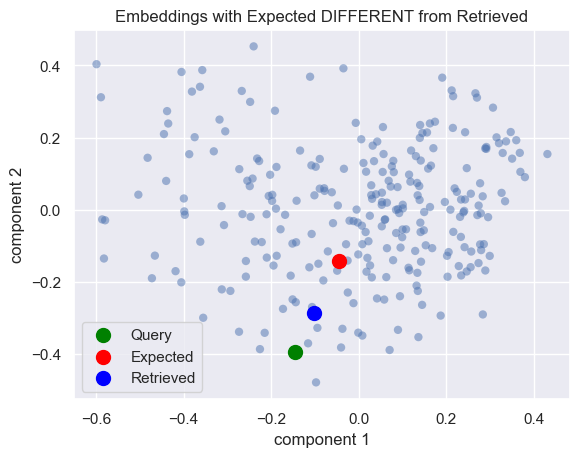

In [70]:
query_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.queries["5377179f-f310-4498-9a81-4a644d21eef6"])
expected_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.corpus["93b772d4-52a6-44a6-a331-0eae1fdf33a5"])
retrieved_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.corpus["e81fb935-4ea8-4a80-867d-ed15f40d0a0c"])

plot_embeddings(projected, query_embedding, expected_embedding, retrieved_embedding)

# Expected in retrieved

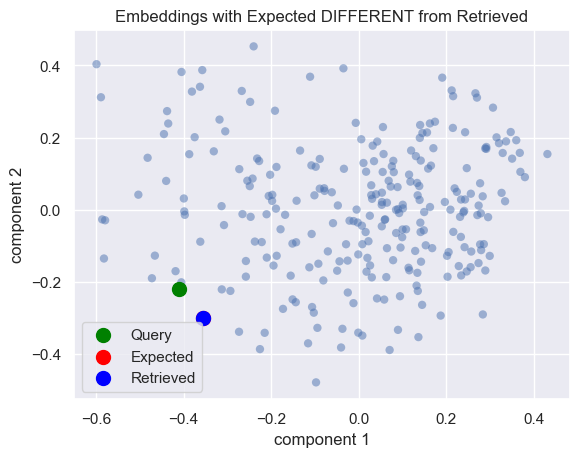

In [72]:
query_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.queries["6c67a361-1d84-4876-8ed5-72e11dd2f21e"])
expected_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.corpus["80b9998c-32d4-42f7-94a7-1a36155b382b"])
retrieved_embedding = embed_model_paraphrase_l12.get_text_embedding(it_dataset.corpus["80b9998c-32d4-42f7-94a7-1a36155b382b"])

plot_embeddings(projected, query_embedding, expected_embedding, retrieved_embedding)

In [76]:
df_results_embedding = pd.DataFrame()
df_results_embedding["model"] = ["paraphrase-multilingual-MiniLM-L12-v2"]
df_results_embedding["top_k"] = [top_k]
df_results_embedding["mrr"] = df_paraphrase_l12_results_it["mrr"].mean()
df_results_embedding["is_hit"] = df_paraphrase_l12_results_it["is_hit"].mean()
df_results_embedding.head()

,model,top_k,mrr,is_hit
0,paraphrase-multilingual-MiniLM-L12-v2,5,0.530641,0.653846
